# UbiSample solution

The core idea is that in a given bin of MAX yearly consumption (**PMAX**) the buildings behave self similar. We assume that hourly distribution of power consumption of the the buildings in such a PMAX bin are drawn from a single distribution. To generate the synthetic data we use **inverse transform sampling** per PMAX bin every hour. 

We found that a bin of 50 buildings reaches a good balance between statistical significant number of hourly points to construct a cumulative distribution (CDF) and natural variability of building patterns with the PMAX bin. Before constructing the CDF we normalise the power consumption. As a last step we scale the normalised synthetic datasets such that we make a distribution of the 95 percentile vales in the PMAX bin and randomly asign maximal consumption to each building.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(33)
import seaborn as sns
from CDF_sampler_final import generate_new_samples, make_new_dataset

# Real data reading

In [ ]:
real_data =pd.read_csv("smart_meters_london_2013.csv")

real_data['datetime'] = pd.to_datetime(real_data['timestamp'])
real_data.set_index('datetime', inplace=True)

real_data.index = real_data.index.tz_localize(tz = 'UTC', ambiguous=True)
real_data.drop(columns="timestamp", inplace =True)

real_data.index = real_data.index.rename("timestamp")
real_data.head()

,0,1,2,3,4,5,6,7,8,9,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,0.460,3.888,0.000,0.207,0.0,0.451,0.962,0.579,0.016,0.660,...,0.585,0.256,3.311,0.190,0.263,0.246,0.141,0.547,0.215,0.119
2013-01-01 01:00:00+00:00,0.426,2.603,0.158,0.106,0.0,0.375,1.121,1.340,0.107,0.420,...,0.493,0.192,1.695,0.222,0.231,0.221,0.131,0.474,0.227,0.103
2013-01-01 02:00:00+00:00,0.411,2.159,0.000,0.069,0.0,0.312,0.373,1.431,0.024,0.242,...,0.423,0.200,1.038,0.268,0.236,0.207,0.131,0.252,0.220,0.285
2013-01-01 03:00:00+00:00,0.395,2.040,0.170,0.065,0.0,0.199,0.421,0.413,0.010,0.149,...,0.182,0.262,0.586,0.119,0.188,0.220,0.104,0.091,0.202,0.097
2013-01-01 04:00:00+00:00,0.221,1.495,0.000,0.058,0.0,0.096,0.303,0.230,0.107,0.280,...,0.262,0.205,0.555,0.149,0.165,0.238,0.119,0.086,0.208,0.103


## making percentile distribution for quick compariosn

In [5]:
percents = real_data.describe(percentiles=np.array([5,15,50,85,95])*0.01)

## Sorting the observations based on Max consumed power

In [9]:
max_values = real_data.max(axis=0)
sorted_columns = max_values.sort_values(ascending=False).index

real_data_sorted = real_data[sorted_columns]
columns = real_data_sorted.columns
real_data_sorted

,1341,3995,3078,857,699,2498,3174,1674,3467,3710,...,145,1369,287,2195,4103,3429,951,1719,1539,2660
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1.022,4.191,2.748,1.838,1.212,0.181,1.693,1.220,0.097,11.780,...,0.051,0.125,0.030,0.058,0.047,0.0,0.070,0.020,0.0,0.0
2013-01-01 01:00:00+00:00,1.117,4.188,2.808,1.530,1.246,0.126,1.575,1.170,0.506,10.060,...,0.045,0.084,0.027,0.165,0.044,0.0,0.048,0.020,0.0,0.0
2013-01-01 02:00:00+00:00,1.025,3.748,2.688,1.036,1.230,0.105,0.637,0.164,0.113,5.562,...,0.052,0.126,0.023,0.075,0.044,0.0,0.070,0.020,0.0,0.0
2013-01-01 03:00:00+00:00,1.109,1.154,2.845,0.851,1.240,0.110,0.643,0.108,0.112,3.276,...,0.111,0.086,0.031,0.000,0.048,0.0,0.070,0.021,0.0,0.0
2013-01-01 04:00:00+00:00,1.299,1.101,2.756,0.829,1.270,0.117,0.658,0.115,0.133,2.979,...,0.119,0.096,0.020,0.000,0.045,0.0,0.060,0.020,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00+00:00,0.877,1.820,6.611,8.212,2.629,0.687,0.744,5.672,9.061,0.670,...,0.197,0.000,0.025,0.082,0.052,0.0,0.055,0.010,0.0,0.0
2013-12-31 20:00:00+00:00,0.923,1.840,7.728,5.448,2.649,0.630,1.451,5.615,7.760,0.714,...,0.210,0.000,0.026,0.081,0.058,0.0,0.034,0.010,0.0,0.0
2013-12-31 21:00:00+00:00,0.956,1.765,5.189,2.874,2.589,0.701,2.965,3.428,4.990,1.458,...,0.202,0.000,0.023,0.109,0.055,0.0,0.056,0.010,0.0,0.0


In [10]:
synthetic_data_ = []
PMAX_Step  = 50 
col_to_normalise = "max"
col_to_renormalise = "max"

for i_max in np.arange(PMAX_Step, len(columns)+1, PMAX_Step):
    print(i_max)
    
    if len(columns[i_max-PMAX_Step:i_max])<2:
        print("not enough data Skipping")
        continue

    # adding an offset
    normalisation = percents.loc[col_to_normalise, columns[i_max-PMAX_Step:i_max]]

    _ = make_new_dataset(real_data_sorted[columns[i_max-PMAX_Step:i_max]],round=False, seed=10)/normalisation

    renorm = generate_new_samples(percents.loc[col_to_renormalise, _.columns],\
                                   num_samples=len( _.columns), round=False, seed=10)
    synthetic_data_.append(np.round( _* renorm, 3) )
    
synthetic_data = pd.concat(synthetic_data_, axis = 1)
synthetic_data.head()



50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100


,1341,3995,3078,857,699,2498,3174,1674,3467,3710,...,78,1780,2206,628,240,297,3324,4054,1785,1365
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1.660,0.017,1.267,2.222,0.919,0.263,0.252,2.586,0.205,0.105,...,0.151,0.302,0.050,0.365,0.079,0.279,0.074,0.404,0.079,0.051
2013-01-01 01:00:00+00:00,1.680,0.036,1.296,2.341,0.849,0.257,0.193,2.684,0.179,0.104,...,0.103,0.244,0.044,0.287,0.056,0.228,0.056,0.309,0.056,0.041
2013-01-01 02:00:00+00:00,1.005,0.021,0.921,1.387,0.450,0.132,0.119,1.596,0.117,0.085,...,0.090,0.211,0.027,0.250,0.045,0.154,0.044,0.273,0.045,0.029
2013-01-01 03:00:00+00:00,0.759,0.020,0.831,1.007,0.446,0.114,0.118,1.168,0.099,0.086,...,0.078,0.152,0.027,0.168,0.040,0.146,0.033,0.246,0.041,0.026
2013-01-01 04:00:00+00:00,0.872,0.027,0.827,1.123,0.519,0.132,0.134,1.324,0.116,0.093,...,0.078,0.135,0.028,0.184,0.046,0.128,0.044,0.240,0.046,0.029


In [11]:
percents_synthetic = synthetic_data.describe(percentiles=np.array([5,15,50,85,95])*0.01)
percents_synthetic

,1341,3995,3078,857,699,2498,3174,1674,3467,3710,...,78,1780,2206,628,240,297,3324,4054,1785,1365
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,1.122136,0.029410,0.861860,1.431148,0.530878,0.167677,0.160995,1.706316,0.146523,0.093076,...,0.141777,0.260257,0.049296,0.298680,0.089066,0.239372,0.077488,0.332096,0.085336,0.045205
std,0.670134,0.011835,0.478267,0.826388,0.293138,0.070916,0.067020,0.999156,0.060925,0.038261,...,0.047967,0.070693,0.021045,0.076973,0.035921,0.069246,0.032025,0.081462,0.035006,0.019683
min,0.255000,0.000000,0.228000,0.307000,0.157000,0.065000,0.063000,0.374000,0.058000,0.030000,...,0.058000,0.119000,0.017000,0.136000,0.034000,0.098000,0.026000,0.147000,0.031000,0.014000
5%,0.395000,0.015000,0.327000,0.511000,0.227000,0.089000,0.088000,0.606000,0.083000,0.053000,...,0.080000,0.147000,0.026000,0.169000,0.047000,0.138000,0.042000,0.191950,0.046000,0.023000
15%,0.544850,0.018000,0.416850,0.687000,0.279000,0.104000,0.100000,0.819850,0.093000,0.062000,...,0.092000,0.166000,0.030000,0.199000,0.054000,0.152000,0.047000,0.231000,0.052000,0.029000
50%,0.957000,0.028000,0.735000,1.216000,0.432000,0.148000,0.143000,1.456000,0.129000,0.083000,...,0.133000,0.266000,0.044000,0.307000,0.082000,0.240000,0.070000,0.343000,0.078000,0.040000
85%,1.711000,0.040000,1.382000,2.218150,0.839000,0.240000,0.232000,2.628000,0.208000,0.125000,...,0.194000,0.338000,0.069000,0.382000,0.120000,0.316000,0.108000,0.414000,0.116000,0.064000
95%,2.400050,0.050000,1.819000,3.044050,1.140050,0.308050,0.298000,3.651350,0.276000,0.175000,...,0.238000,0.370000,0.091000,0.414000,0.168000,0.360000,0.144000,0.454000,0.162000,0.084000
max,4.818000,0.121000,3.132000,6.546000,2.069000,0.712000,0.609000,7.648000,0.487000,0.346000,...,0.399000,0.603000,0.162000,0.668000,0.315000,0.571000,0.273000,0.741000,0.307000,0.149000


# plotting

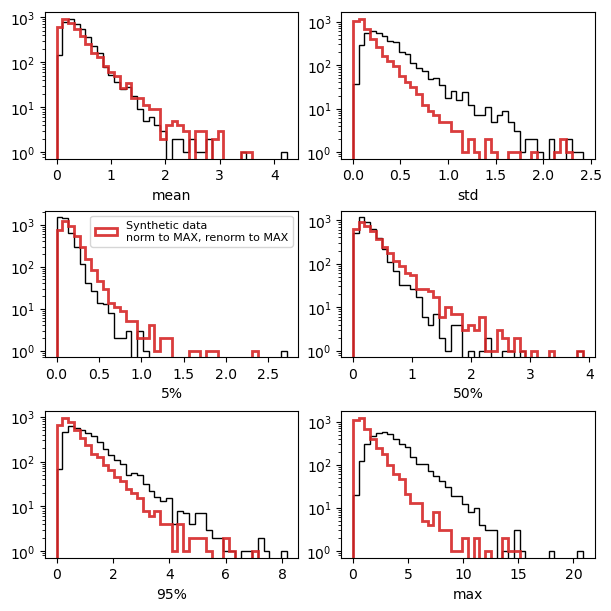

In [12]:
fig, axes = plt.subplots(3,2, figsize = (6,6), constrained_layout = True)

ax = axes.flatten()
for i, col in enumerate(['mean', 'std', '5%', "50%", "95%", "max"]):

    #print(col)
    bins = np.histogram_bin_edges(percents.loc[col], bins = 40)
    ax[i].hist(percents.loc[col], bins = bins, color = "k", histtype = "step")

    ax[i].hist(percents_synthetic.loc[col], bins = bins, color = "C3",\
                histtype = "step", label = "Synthetic data\nnorm to MAX, renorm to MAX", lw = 2, alpha = 0.9)

    #print("ok")
    ax[i].set_xlabel(col)
    ax[i].semilogy()

ax[2].legend(fontsize = 8)
#plt.savefig("fig/Summary_stats_final_results.png")

# Saving

In [ ]:
# If any columns are missing add NaN

for col in real_data.columns.difference(synthetic_data.columns):
    synthetic_data.loc[:, col] = np.nan

synthetic_data

/var/folders/zx/5fhz630d2mj1yx3xvqyly0q80000gn/T/ipykernel_98521/4062240606.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  synthetic_data.loc[:, col] = np.nan
/var/folders/zx/5fhz630d2mj1yx3xvqyly0q80000gn/T/ipykernel_98521/4062240606.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  synthetic_data.loc[:, col] = np.nan
/var/folders/zx/5fhz630d2mj1yx3xvqyly0q80000gn/T/ipykernel_98521/4062240606.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

,1341,3995,3078,857,699,2498,3174,1674,3467,3710,...,2660,287,3429,3556,4103,425,746,805,938,951
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1.660,0.017,1.267,2.222,0.919,0.263,0.252,2.586,0.205,0.105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 01:00:00+00:00,1.680,0.036,1.296,2.341,0.849,0.257,0.193,2.684,0.179,0.104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 02:00:00+00:00,1.005,0.021,0.921,1.387,0.450,0.132,0.119,1.596,0.117,0.085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 03:00:00+00:00,0.759,0.020,0.831,1.007,0.446,0.114,0.118,1.168,0.099,0.086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 04:00:00+00:00,0.872,0.027,0.827,1.123,0.519,0.132,0.134,1.324,0.116,0.093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00+00:00,2.131,0.036,1.381,2.857,0.950,0.356,0.325,3.403,0.273,0.078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31 20:00:00+00:00,2.148,0.016,1.824,2.894,0.990,0.437,0.269,3.418,0.252,0.173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31 21:00:00+00:00,1.717,0.037,1.375,2.296,0.953,0.402,0.426,2.705,0.325,0.160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
name = "mock_data/mock_portfolio_Final_norm_toMAX"
synthetic_data.to_pickle(name+".pickle")
synthetic_data.to_csv(name+".csv")

# Time series plot

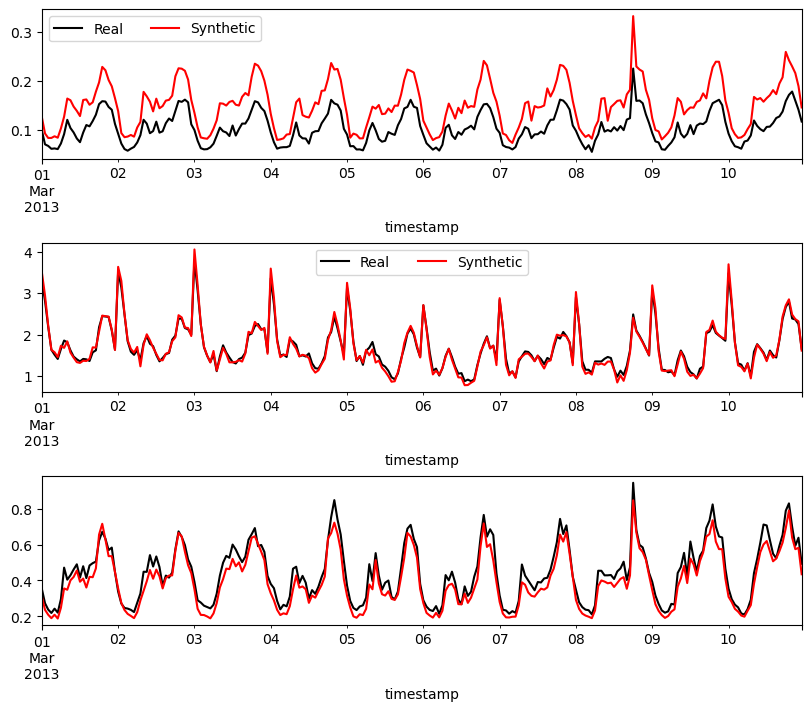

In [53]:
fig, ax = plt.subplots(3, figsize = (8, 7), constrained_layout = True)

real_data_sorted.loc["2013-03-01":"2013-03-10", columns[-50:]].mean(axis = 1).plot(ax = ax[0],c = "k", label = "Real")
synthetic_data.loc["2013-03-01":"2013-03-10", columns[-50:]].mean(axis = 1).plot(ax = ax[0],c = "r", label = "Synthetic")


real_data_sorted.loc["2013-03-01":"2013-03-10", columns[:50]].mean(axis = 1).plot(ax = ax[1],c = "k", label = "Real")
synthetic_data.loc["2013-03-01":"2013-03-10", columns[:50]].mean(axis = 1).plot(ax = ax[1],c = "r", label = "Synthetic")


real_data_sorted.loc["2013-03-01":"2013-03-10", columns[1745:1795]].mean(axis = 1).plot(ax = ax[2],c = "k", label = "Real")
synthetic_data.loc["2013-03-01":"2013-03-10", columns[1745:1795]].mean(axis = 1).plot(ax = ax[2],c = "r", label = "Synthetic")


ax[0].legend(ncols = 2)
ax[1].legend(ncols = 2)